In [2]:
#Part 1:Principal Component Analysis
#Step 1.1
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load Wine dataset
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']


X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)


In [3]:
#Step 1.2
import numpy as np

# Compute covariance matrix
cov_mat = np.cov(X_train_std.T)

# Perform eigendecomposition
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

# Sort eigenvalues in descending order
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

# Create projection matrix (top 2 components)
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))

# Transform training data
X_train_pca = X_train_std.dot(w)

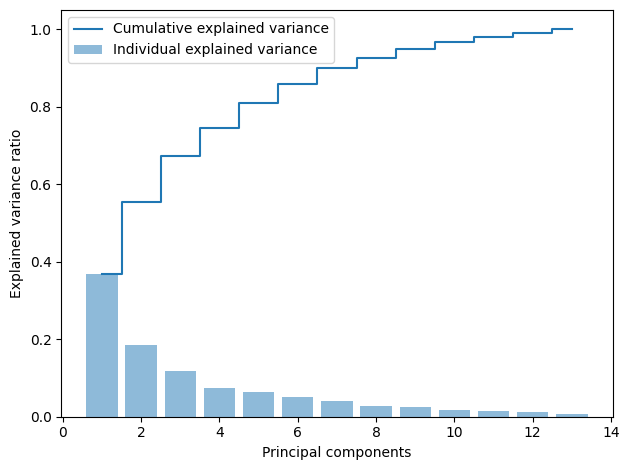

In [4]:
#Step 1.3
import matplotlib.pyplot as plt


tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)


plt.bar(range(1, len(var_exp) + 1), var_exp, alpha=0.5, align='center',
        label='Individual explained variance')
plt.step(range(1, len(cum_var_exp) + 1), cum_var_exp, where='mid',
         label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [5]:
#Step 1.4

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_pca_sk = pca.fit_transform(X_train_std)
X_test_pca_sk = pca.transform(X_test_std)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/tmp/ipython-input-3825494660.py:27: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x=X[y == cl, 0],
/tmp/ipython-input-3825494660.py:27: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


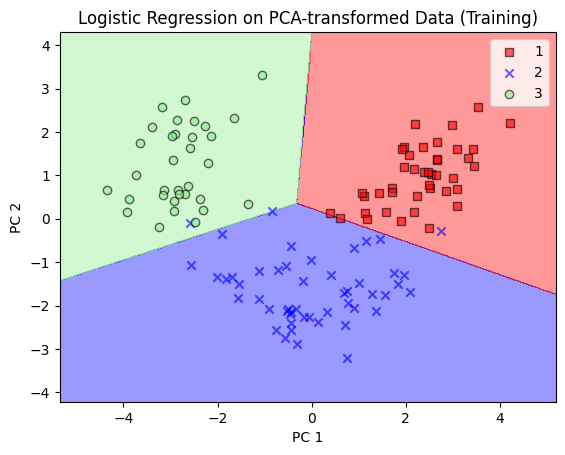

Test Accuracy: 0.926


In [6]:
#Step 1.5

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr.fit(X_train_pca_sk, y_train)


from matplotlib.colors import ListedColormap
def plot_decision_regions(X, y, classifier, resolution=0.02):

    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.6,
                    c=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx],
                    label=cl)
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.legend(loc='best')


plot_decision_regions(X_train_pca_sk, y_train, classifier=lr)
plt.title('Logistic Regression on PCA-transformed Data (Training)')
plt.show()


print('Test Accuracy: %.3f' % lr.score(X_test_pca_sk, y_test))

In [7]:
#Part 2 Linear Discriminant Analysis (LDA)
#Step 2.1


mean_vecs = [np.mean(X_train_std[y_train == label], axis=0) for label in np.unique(y_train)]

d = X.shape[1]
S_W = np.zeros((d, d))
for label, mv in zip(np.unique(y_train), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter


mean_overall = np.mean(X_train_std, axis=0)
S_B = np.zeros((d, d))
for i, mv in enumerate(mean_vecs):
    n = X_train[y_train == i + 1].shape[0]
    mv = mv.reshape(d, 1)
    mean_overall = mean_overall.reshape(d, 1)
    S_B += n * (mv - mean_overall).dot((mv - mean_overall).T)


In [9]:
#Step 2.2

eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))


eigen_pairs = sorted([(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))], key=lambda k: k[0], reverse=True)


w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
               eigen_pairs[1][1][:, np.newaxis].real))


X_train_lda = X_train_std.dot(w)

In [10]:
#Step 2.3
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_train_lda_sk = lda.fit_transform(X_train_std, y_train)
X_test_lda_sk = lda.transform(X_test_std)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/tmp/ipython-input-3825494660.py:27: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x=X[y == cl, 0],
/tmp/ipython-input-3825494660.py:27: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


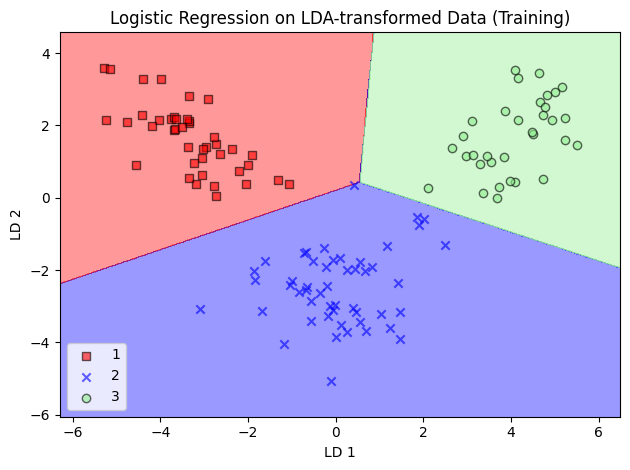

Test Accuracy: 1.000


In [11]:
#Step 2.4
lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr.fit(X_train_lda_sk, y_train)

plot_decision_regions(X_train_lda_sk, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.title('Logistic Regression on LDA-transformed Data (Training)')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

print('Test Accuracy: %.3f' % lr.score(X_test_lda_sk, y_test))

In [17]:
#Part 3
#Step 3.1


from scipy.spatial.distance import pdist, squareform
from scipy.linalg import eigh
import numpy as np


def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF kernel PCA implementation.
    """
    # Calculate pairwise squared Euclidean distances
    sq_dists = pdist(X, 'sqeuclidean')
    # Convert pairwise distances into a square matrix
    mat_sq_dists = squareform(sq_dists)
    # Compute the symmetric kernel matrix
    K = np.exp(-gamma * mat_sq_dists)
    # Center the kernel matrix
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    # Obtaining eigenpairs from the centered kernel matrix
    eigvals, eigvecs = eigh(K)
    # Collect top k eigenvectors (projected samples)
    X_pc = np.column_stack([eigvecs[:, -i] for i in range(1, n_components+1)])
    return X_pc

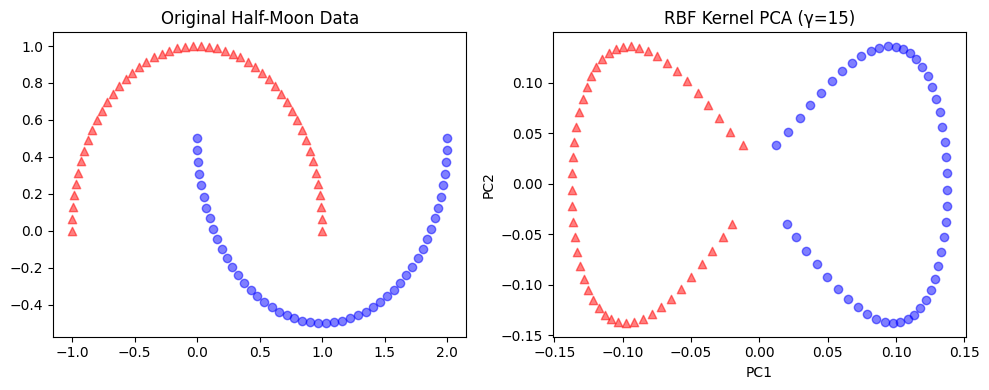

In [18]:
#Step 3.2
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, random_state=123)
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.scatter(X[y==0, 0], X[y==0, 1], color='red', marker='^', alpha=0.5)
ax1.scatter(X[y==1, 0], X[y==1, 1], color='blue', marker='o', alpha=0.5)
ax1.set_title('Original Half-Moon Data')

ax2.scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], color='red', marker='^', alpha=0.5)
ax2.scatter(X_kpca[y==1, 0], X_kpca[y==1, 1], color='blue', marker='o', alpha=0.5)
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_title('RBF Kernel PCA (γ=15)')
plt.tight_layout()
plt.show()

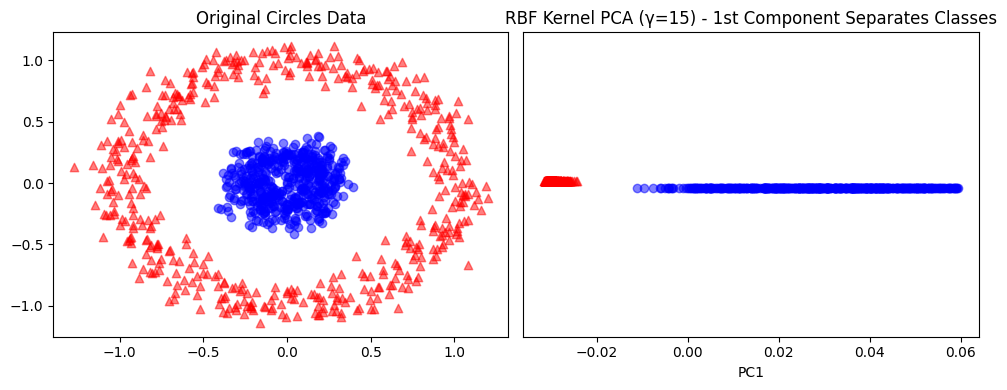

In [19]:
#Step 3.3

from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.scatter(X[y==0, 0], X[y==0, 1], color='red', marker='^', alpha=0.5)
ax1.scatter(X[y==1, 0], X[y==1, 1], color='blue', marker='o', alpha=0.5)
ax1.set_title('Original Circles Data')

ax2.scatter(X_kpca[y==0, 0], np.zeros((500,1)) + 0.02, color='red', marker='^', alpha=0.5) # Add slight y-jitter for visualization
ax2.scatter(X_kpca[y==1, 0], np.zeros((500,1)) - 0.02, color='blue', marker='o', alpha=0.5)
ax2.set_ylim([-1, 1])
ax2.set_yticks([])
ax2.set_xlabel('PC1')
ax2.set_title('RBF Kernel PCA (γ=15) - 1st Component Separates Classes')
plt.tight_layout()
plt.show()


In [20]:
#Step 3.4
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_kpca_sk = kpca.fit_transform(X)


ANALYSIS QUESTIONS

1. PCA orders components by descending variance; the explained_variance_ratio_ tells you how much variance each PC captures. The cumulative sum increases monotonically toward 1 as you add PCs.≥95% variance is reached at 10 components

2. Because LDA uses labels to optimize separability, it typically yields projections that are better suited for classification than PCA used purely as preprocessing

3. Too small (=0.01) - underfits (almost linear). Moderate (=5-15) often yields a feature space where the moons are most linearly separable. Too large (≥50-100) overfits/over-localizes and hurts linear separability

4. Reducing to 2 PCs sacrifices accuracy versus the full space or LDA, but trains/predicts slightly faster.

PCA at 95% variance (10 comps) kept perfect accuracy while reducing dimensionality from 13→10 with modest speed gains.

LDA-2 achieved perfect accuracy with both classifiers and was also among the fastest—consistent with LDA optimizing class separation directly.

5. PCA is linear; it cannot “unroll” nonlinear structure. Classic failures are concentric circles or two moons—data that are not linearly separable in the original space. PCA preserves directions of maximum variance but won’t create a linear split for such manifolds.

Kernel PCA performs PCA in a high-dimensional feature space implicitly defined by a kernel. Nonlinear relationships in input space can become linearly separable in that feature space; the result is obtained via an eigenvalue problem on the centered kernel matrix (the “kernel trick”).